In [1]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
import pyart
import xarray as xr
import pandas as pd
%pylab inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/dask/compatibility.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PY_VERSION = LooseVersion(".".join(map(str, sys.version_info[:3])))
/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/dask/array/numpy_compat.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _numpy_117 = LooseVersion(np.__version__) >= "1.17.0"
/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/dask/array/numpy_compat.py:9: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _numpy_118 = LooseVersion(np.__version__) >= "1.18.0"
/home/rjackson/.conda/envs/pydda

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
Gen = ImageDataGenerator(rescale=1/255.)
dataset = Gen.flow_from_directory(
    '/lcrc/group/earthscience/rjackson/lidar_pngs/5min_snr/training', class_mode='input', target_size=(256, 192), shuffle=False)

#inp, encoder, decoded = encoder_decoder_model()
model = load_model('/lcrc/group/earthscience/rjackson/arming_the_edge/encoder/encoder-decoder-1999.hdf5')
encoder = Model(model.get_layer("input").output, model.get_layer("encoding").output)
encodings = encoder.predict(dataset)

Found 13707 images belonging to 3 classes.


2022-06-17 07:55:32.481703: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 07:55:34.795884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-06-17 07:55:37.960557: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-06-17 07:55:40.953606: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [3]:
times = []
for fname in dataset.filepaths:
    filename = fname.split('/')[-1].split('.')
    base_date = datetime.datetime.strptime('%s.%s' % (filename[2], filename[3]), '%Y%m%d.%H%M%S')
    str_num = filename[4].split('moments')[1]
    if 'checkpoint' in str_num:
        print(fname)
        str_num = str_num[:-11]
        
    num_times = int(str_num)
    times.append(base_date + timedelta(minutes=5*num_times))

In [38]:
my = 'moments4'
my = my.split('moments')
my

['', '4']

In [4]:
encodings = encodings.reshape((encodings.shape[0], np.prod(encodings.shape[1:])))
encodings.shape

(13707, 3072)

In [15]:
## Reduce to 10-dimensional space

In [5]:
model = PCA(n_components=10)
model.fit(encodings)

PCA(n_components=10)

In [6]:
reduced = model.transform(encodings)
reduced.shape

(13707, 10)

In [9]:
encodings.shape

(13707, 3072)

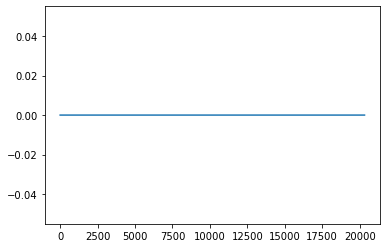

In [8]:
plt.plot(encodings[:, 29])

In [27]:
rand_data = np.random.rand(*encodings.shape)

In [ ]:
from sklearn.metrics import silhouette_score
inertia = np.nan*np.ones(40)
for i in range(1, 50):
    print(i)
    km = KMeans(n_clusters=i)
    km.fit(encodings)
    label = km.predict(encodings)
    km_rand = KMeans(n_clusters=i)
    km_rand.fit(rand_data)
    inertia[i] = np.log10(km_rand.inertia_) - np.log10(km.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


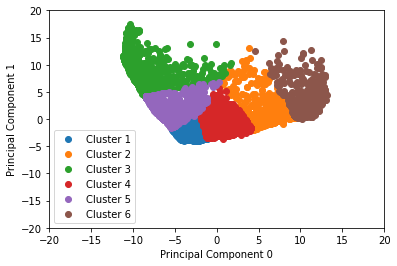

In [106]:
for i in range(3):
    plt.scatter(reduced[cluster_no == i, 0], reduced[cluster_no == i, 1], label='Cluster %d' % (i + 1))
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.legend()
plt.savefig('PC_clusters3.png')

In [ ]:
plt.figure(figsize=(7, 4))    
plt.plot(np.arange(1, 50), inertia[1:], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Gap statistic')
plt.ylim([0, 1.2])
plt.savefig('Clusters.png', dpi=300, bbox_inches='tight')
print(np.diff(inertia))

In [ ]:
from sklearn.metrics import pairwise_distances
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max=5, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        print(k)
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        print(k)
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 10
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(), reduced, k_max)


plt.plot(range(1, k_max+1), reference_inertia,
         '-o', label='reference')
plt.plot(range(1, k_max+1), ondata_inertia,
         '-o', label='data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.show()

In [7]:
cluster = KMeans(n_clusters=10, random_state=42)
cluster.fit(reduced)
cluster_no = cluster.labels_

/tmp/ipykernel_2178070/1377204831.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[i % 3][int(i/3)].pcolormesh(-np.ones_like(img[0]), -np.ones_like(img[0]),


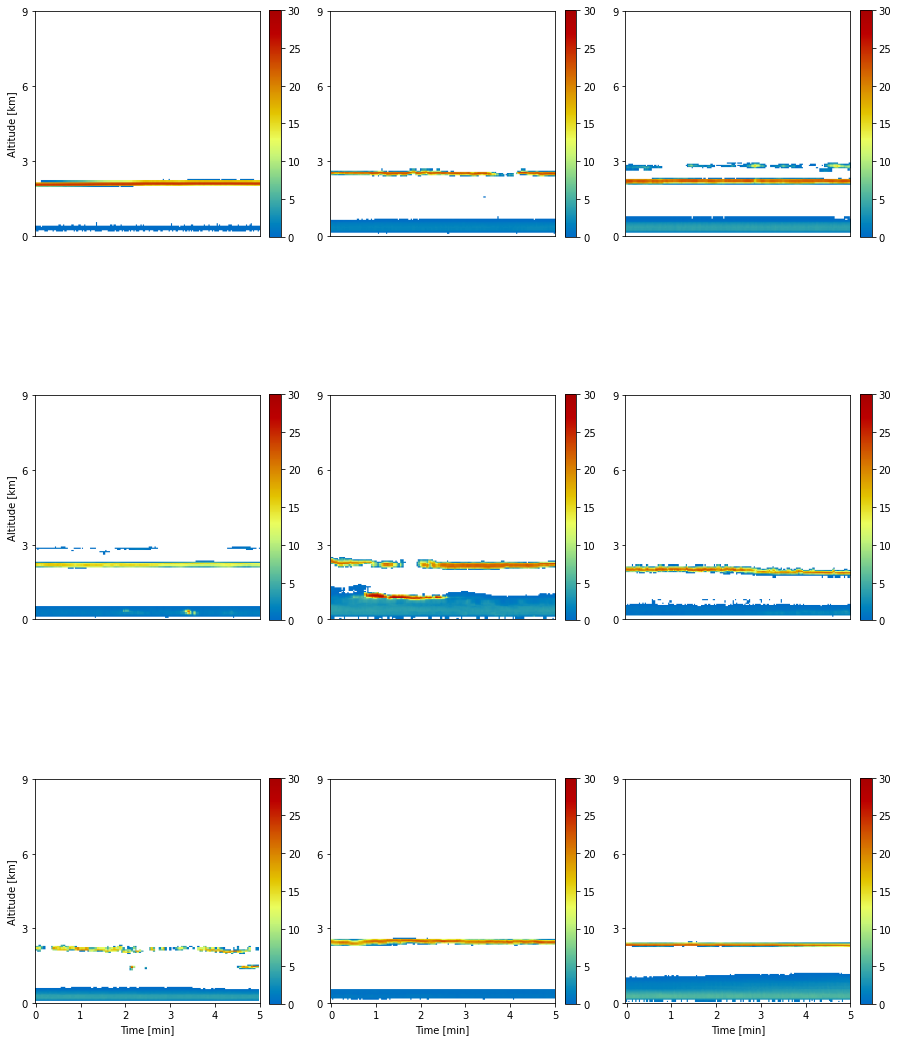

In [27]:
which = 9
cluster_ind = np.squeeze(np.argwhere(cluster_no == which))
fig, ax = plt.subplots(3, 3, figsize=(15, 20))
for i in range(9):
    choice = np.random.choice(cluster_ind)
    batch_no = int(np.floor(choice / 32))
    img_no = choice % 32
    img = np.squeeze(dataset[batch_no][0][img_no])
    im = ax[i % 3][int(i/3)].imshow(img[:, :])
    im = ax[i % 3][int(i/3)].pcolormesh(-np.ones_like(img[0]), -np.ones_like(img[0]), 
                                   img[0], cmap='pyart_HomeyerRainbow', vmin=0, vmax=30)
    ax[i % 3][int(i/3)].set_ylim([64, 256])
    ax[i % 3][int(i/3)].set_yticks(np.linspace(64, 256, 4))
    ax[i % 3][int(i/3)].set_yticklabels(['%d' % x for x in np.linspace(9, 0, 4)])
    ax[i % 3][int(i/3)].invert_yaxis()
    if i % 3 == 2:
        ax[i % 3][int(i/3)].set_xticks(np.linspace(0, 192, 6))
        ax[i % 3][int(i/3)].set_xticklabels(['0', '1', '2', '3', '4', '5'])
        ax[i % 3][int(i/3)].set_xlabel('Time [min]')
    else:
        ax[i % 3][int(i/3)].set_xticks([])
        
    if(int(i/3) == 0):
        ax[i % 3][int(i/3)].set_ylabel("Altitude [km]")

    bar = plt.colorbar(im, ax=ax[i % 3][int(i/3)], fraction=0.046, pad=0.04)
        
    #ax[i % 3][int(i/3)].axis('off')
    fig.savefig('cluster%d.png' % which)

In [ ]:
which = 0
cluster_ind = np.argwhere(cluster_no == which)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
img = np.squeeze(np.zeros_like(dataset[0][0][0]))
for i in range(len(cluster_ind)):
    batch_no = int(np.floor(cluster_ind[i] / 32))
    img_no = cluster_ind[i] % 32
    img = img + np.squeeze(dataset[batch_no][0][img_no])
img = img/len(cluster_ind)
plt.imshow(img)

In [18]:
scp_ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/sgp_lidar/coverage_product/*.nc')

/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [16]:
times_unique = np.unique(times)
print(times_unique.shape)
print(len(times))

(13707,)
13707


In [28]:
cluster_ds = xr.Dataset({'time': ('time', np.array(times)), 'classification': ('time', cluster_no)})
cluster_ds = cluster_ds.sortby('time')
cluster_ds = cluster_ds.reindex(time=scp_ds.time, method='nearest')
cluster_ds.to_netcdf('Clusters_new10.nc')

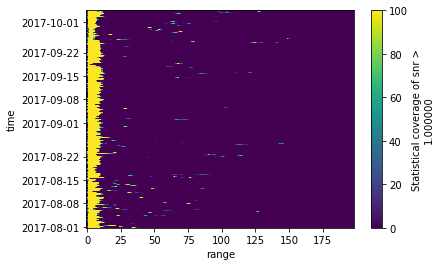

In [28]:
scp_ds['snrgt1.000000'].plot()

In [ ]:
cluster_ds
scp_ds.load()

In [ ]:
cluster_ds_new = cluster_ds.reindex(time=times, method='nearest')
cluster_no = cluster_ds_new.classification.values

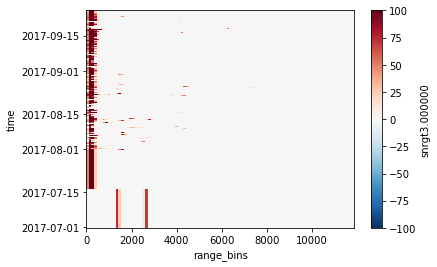

In [51]:
scp_ds['snrgt3.000000'].plot()

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


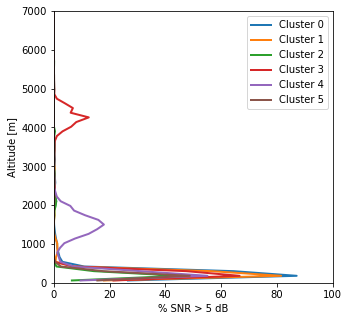

In [22]:
scp_ds = scp_ds.fillna(-1)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for cl in range(6):
    inds = np.argwhere(cluster_ds.classification.values == cl)
    hist_bins = np.linspace(0, 100., 50)
    x, y = np.meshgrid(hist_bins[1:], scp_ds.range_bins.values, indexing='ij')
    mean_d = np.zeros((len(scp_ds.range_bins),))
    ninety_d = np.zeros((len(scp_ds.range_bins),))
    ten_d = np.zeros((len(scp_ds.range_bins),))
    for i in range(len(scp_ds.range_bins)):
        mean_d[i] = np.nanmean(scp_ds['snrgt5.000000'].values[inds, i])
        ninety_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 90)
        ten_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 10)
    ninety_d = np.where(ninety_d > 0, ninety_d, 0.001)
    ten_d = np.where(ten_d > 0, ten_d, 0.001)
    ax.plot(mean_d, scp_ds.range_bins.values, linewidth=2, label='Cluster %d' % cl)
    #ax.set_title('Cluster %d' % cl)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 7000])
    ax.set_xlabel('% SNR > 5 dB')
    ax.set_ylabel('Altitude [m]')
ax.legend()
fig.savefig('SNRgt5.png', dpi=300)

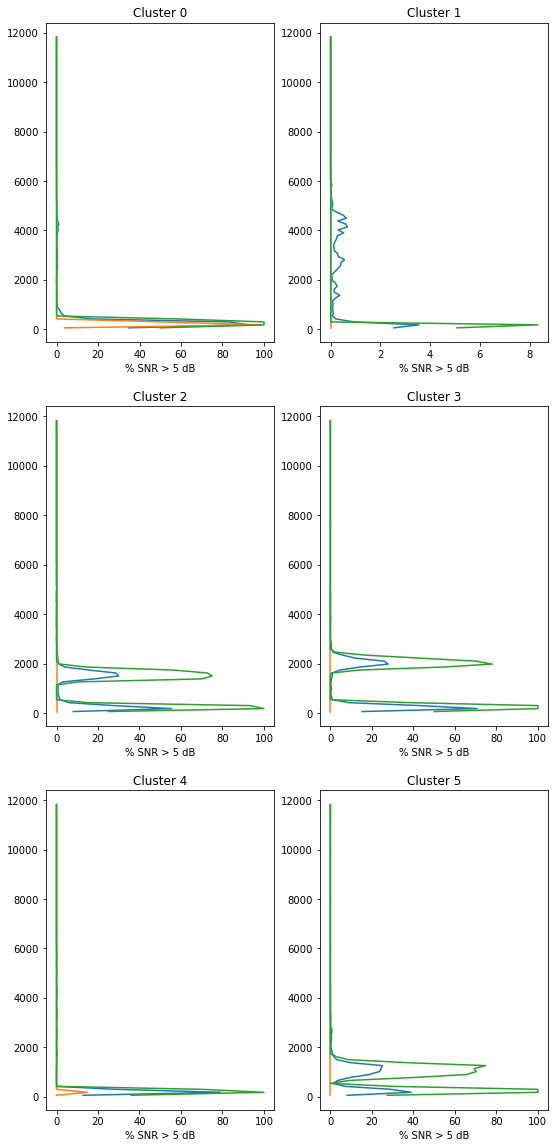

In [108]:
scp_ds = scp_ds.fillna(-1)
fig, ax = plt.subplots(3, 2, figsize=(9, 20))
for cl in range(6):
    inds = np.argwhere(cluster_ds.classification.values == cl)
    hist_bins = np.linspace(0, 100., 50)
    x, y = np.meshgrid(hist_bins[1:], scp_ds.range_bins.values, indexing='ij')
    mean_d = np.zeros((len(scp_ds.range_bins),))
    ninety_d = np.zeros((len(scp_ds.range_bins),))
    ten_d = np.zeros((len(scp_ds.range_bins),))
    for i in range(len(scp_ds.range_bins)):
        mean_d[i] = np.nanmean(scp_ds['snrgt5.000000'].values[inds, i])
        ninety_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 90)
        ten_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 10)
    ax[int(cl/2), cl%2].plot(mean_d, scp_ds.range_bins.values)
    ax[int(cl/2), cl%2].plot(ten_d, scp_ds.range_bins.values)
    ax[int(cl/2), cl%2].plot(ninety_d, scp_ds.range_bins.values)
    ax[int(cl/2), cl%2].set_title('Cluster %d' % cl)
    ax[int(cl/2), cl%2].set_xlabel('% SNR > 5 dB')

In [4]:
label_df = pd.read_csv('../notebooks/lidar_labels.csv')

date_list = np.array([datetime.datetime.strptime(x, '%Y-%m-%d').timetuple().tm_yday for x in label_df["Date"].values])
start_time_list = np.array([datetime.datetime.strptime(x[0:4], '%H%M').time() for x in label_df["Time"].values])
end_time_list = np.array([datetime.datetime.strptime(x[5:], '%H%M').time() for x in label_df["Time"].values])


def get_label(dt):
    label_ind = np.where(np.logical_and.reduce(
        (date_list == dt.dayofyear.values, start_time_list <= dt.time.values, end_time_list > dt.time.values)))
    if not label_ind[0].size:
        return -1
    my_strings = np.array(
            [x.lower() for x in label_df["Label"].values[label_ind]])
    num_cloud = len(np.where(my_strings == "cloudy")[0]) + \
            len(np.where(my_strings == "cloud")[0])
    num_clear = len(np.where(my_strings == "clear")[0])
    num_rain = len(np.where(my_strings == "rain")[0])
    my_string = label_df["Label"].values[label_ind][0]

    pct_cloud = num_cloud/len(my_strings)

    if num_rain > 0:
        return 2
    elif pct_cloud == 0:
        return 0
    else:
        return 1

    raise ValueError("Invalid value %s for label" % my_string)

labels = np.array([get_label(x.dt) for x in cluster_ds.time])

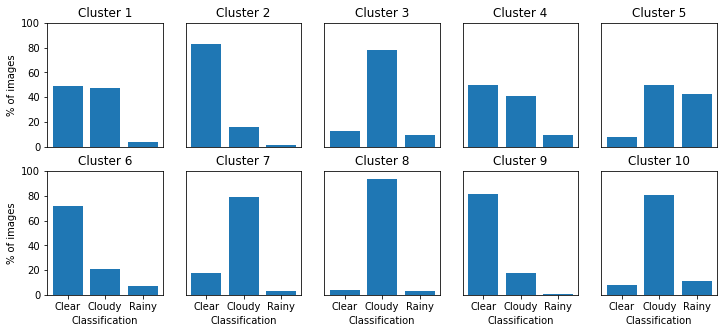

In [8]:
cluster_ds = xr.open_dataset('Clusters_new10.nc')
#cluster_ds = xr.Dataset({'time': ('time', np.array(times)), 'classification': ('time', cluster_no)})
#cluster_ds = cluster_ds.sortby('time')
fig, ax = plt.subplots(2, 5, figsize=(12, 5))
for cl in range(10):
    inds = np.argwhere(cluster_ds.classification.values == cl)
    num_clear = np.sum(labels[inds] == 0)
    num_cloudy = np.sum(labels[inds] == 1)
    num_rainy = np.sum(labels[inds] == 2)
    ax[int(cl/5), cl % 5].bar([0, 1, 2], np.array([num_clear, num_cloudy, num_rainy])/(num_clear + num_cloudy + num_rainy)*100)
    ax[int(cl/5), cl % 5].set_xticks([0, 1, 2])
    ax[int(cl/5), cl % 5].set_xticklabels(['Clear', 'Cloudy', 'Rainy'])
    if cl % 5 == 0:
        ax[int(cl/5), cl % 5].set_ylabel('% of images')
    else:
        ax[int(cl/5), cl % 5].set_yticks([])
    if cl >= 5:
        ax[int(cl/5), cl % 5].set_xlabel('Classification')
    else:
        ax[int(cl/5), cl % 5].set_xticks([])
    ax[int(cl/5), cl % 5].set_ylim([0, 100])
    ax[int(cl/5), cl % 5].set_title('Cluster %d' % (cl + 1))
#ax[-1,-1].axis('off')
fig.savefig('label_dist10.png', dpi=300, bbox_inches='tight')

In [13]:
len(times)

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10740